# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from Spike_Generation import NL

importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
def NGDcSTA(x, alpha, beta, Kg, tau_y, Amp):
    dt = 1/60
    stimulus = x.copy()
    T = np.arange(0,int(tau_y/dt*8))*dt
    Ky = T/tau_y /tau_y *np.exp(-T/tau_y)
    sstm = np.zeros_like(stimulus)
    for i in range(len(Ky)-1):
        for ii in range(i+1):
            sstm[i] += stimulus[ii]*Ky[i-ii]*dt
        sx = np.convolve(stimulus,Ky,'valid')*dt
        sstm[len(Ky)-1:] = sx.copy()

    y=np.zeros_like(sstm)
    z=np.zeros_like(sstm)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+(sstm[j]-z[j]))
        dz=dt*(-beta*z[j]+Kg*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz

    fcSTA = np.correlate(x , NL(-y,0), 'same')/ np.correlate(np.ones_like(x ), NL(-y,0), 'same')
    fcSTA = fcSTA[int(len(fcSTA)/2):int(len(fcSTA)/2-1/dt)-1:-1]
    return  Amp*fcSTA

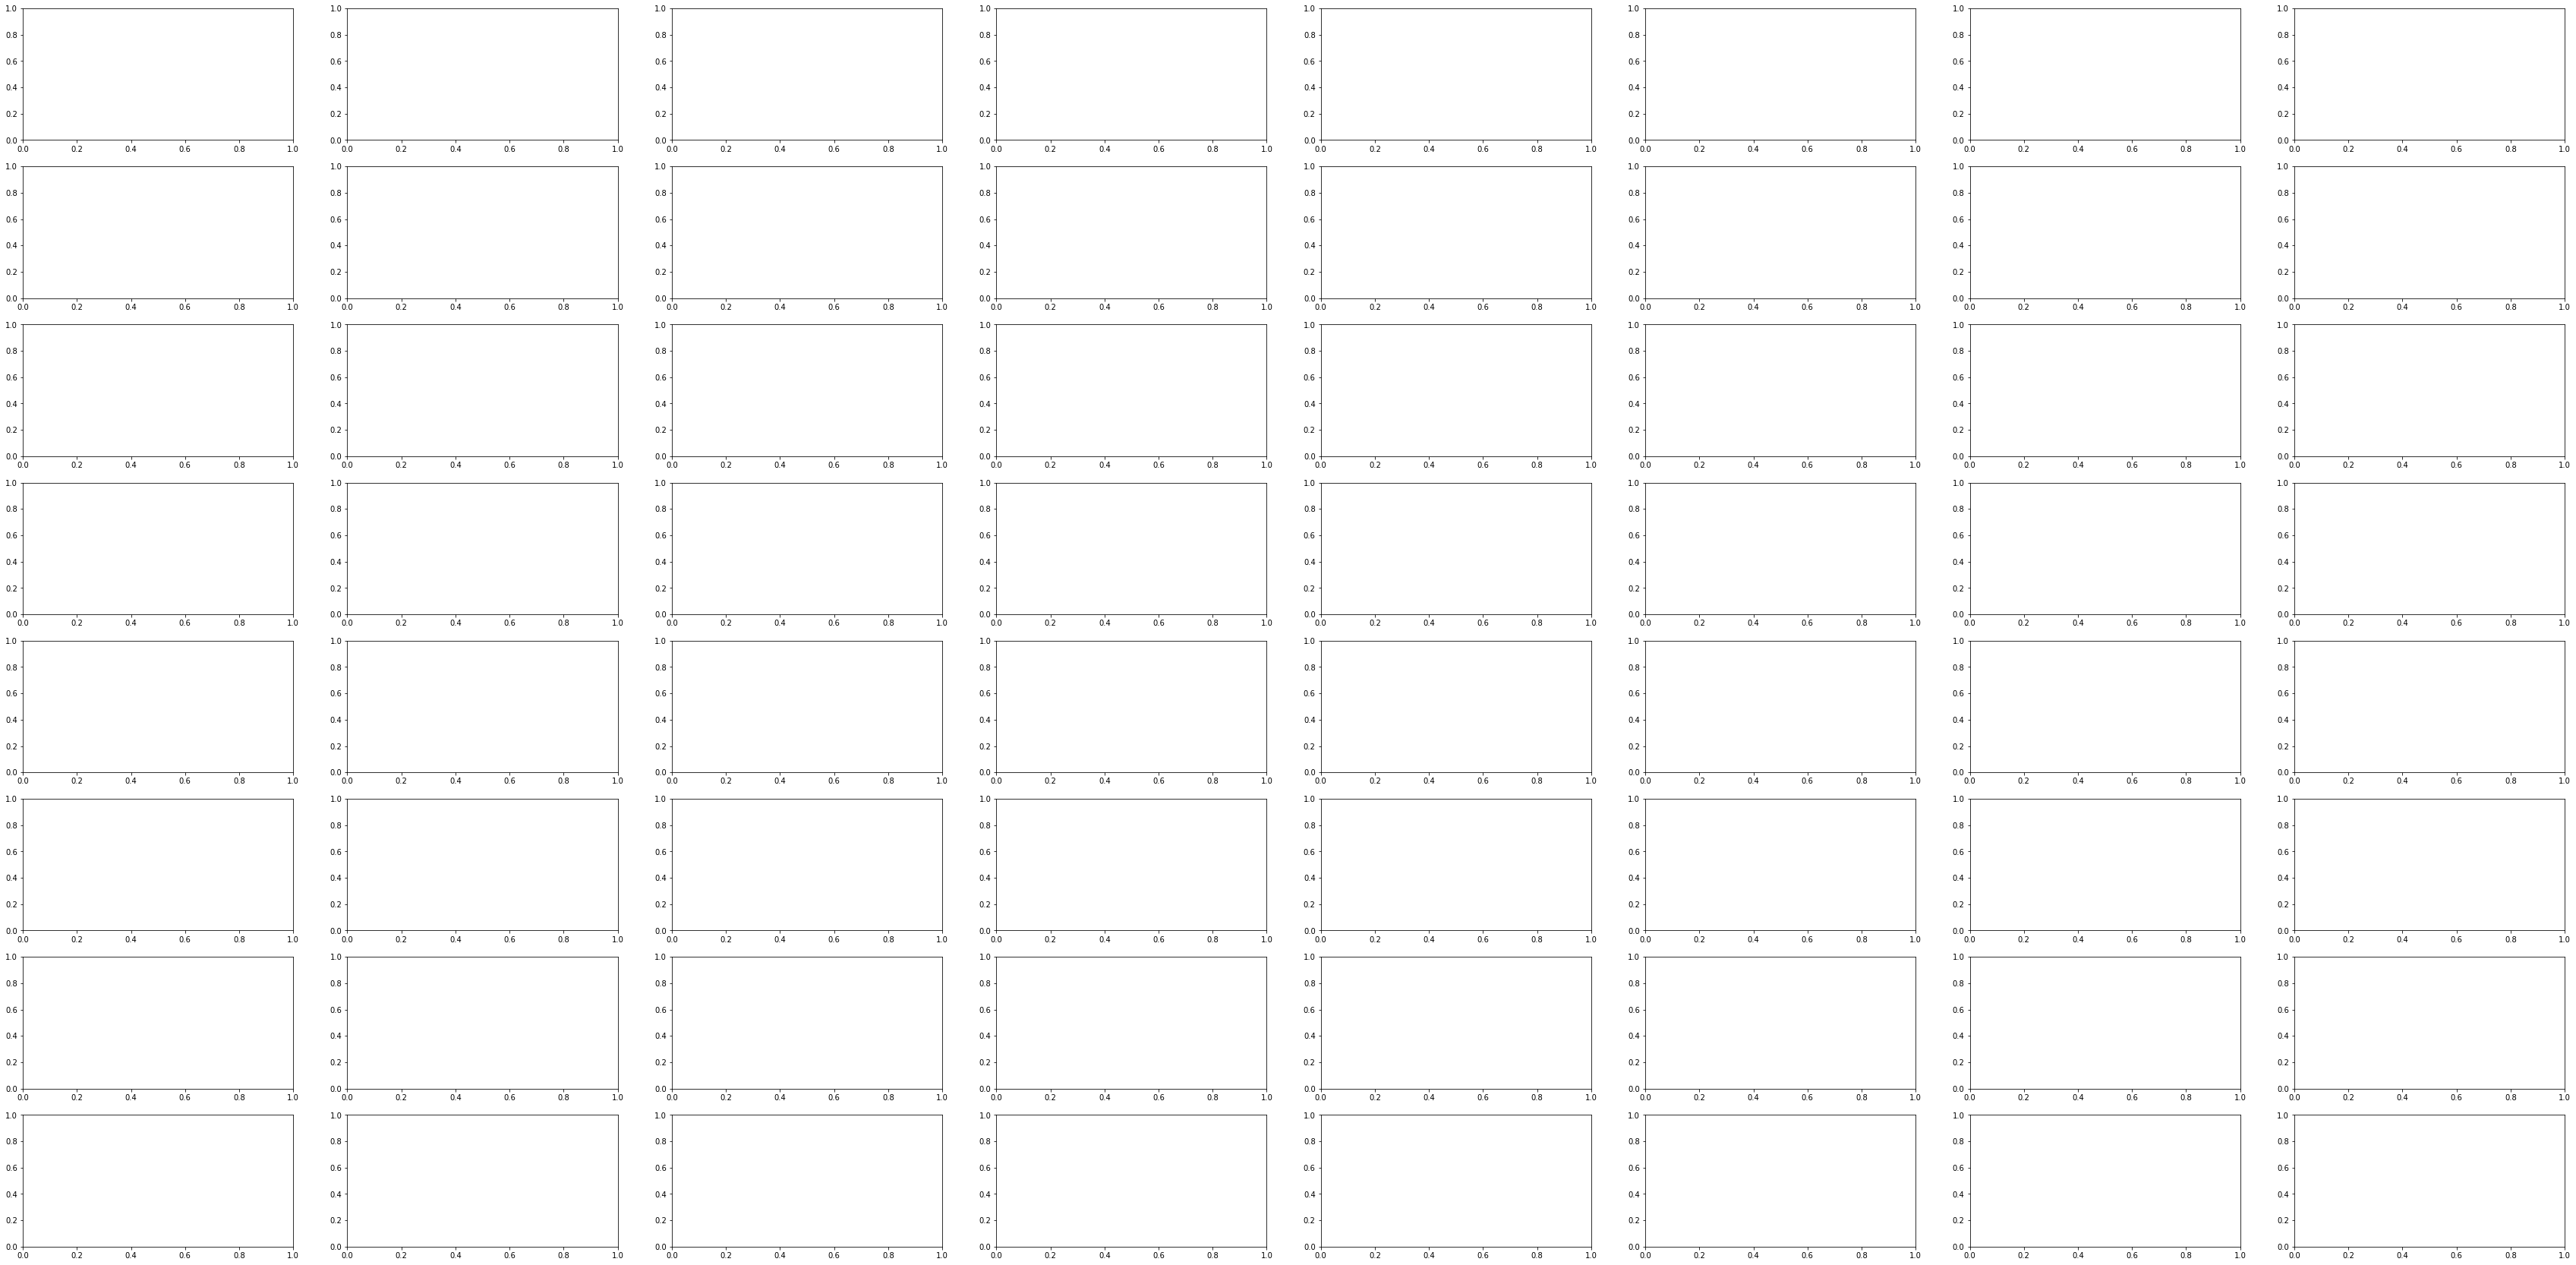

In [4]:
figmap = [[np.nan, 7,15,23,31,39,47,np.nan],
          [     1, 8,16,24,32,40,48,    55],
          [     2, 9,17,25,33,41,49,    56],
          [     3,10,18,26,34,42,50,    57],
          [     4,11,19,27,35,43,51,    58],
          [     5,12,20,28,36,44,52,    59],
          [     6,13,21,29,37,45,53,    60],
          [np.nan,14,22,30,38,46,54,np.nan]]
figmap = np.array(figmap)
fig, ax = plt.subplots(nrows=8, ncols=8)
fig.set_size_inches(60, 30)

# main

In [5]:
annots = loadmat('D:\\GoogleDrive\\retina\\Chou\'s data\\20210413\\merge\\merge_0224_cSTA_wf_3min_Q100_re' 
                 , squeeze_me = True)
x = annots['bin_pos']
x = x-np.mean(x)
dt = 1/60
cSTA_list = [0]*60
dcn = []
for cn in range(60):
    spike = annots['reconstruct_spikes'][cn]
#     if type(spike) == float: continue
#     elif len(spike)/((len(x)+1)*dt) < 0.3: continue
    rstate, _ = np.histogram(spike, np.arange(len(x)+1)*dt)
    
    cSTA = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
    cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
    taxis = -np.arange(len(cSTA))*dt
    if (np.abs(cSTA[:round(len(cSTA)/2)]) < 7*np.std(cSTA[round(len(cSTA)/2):-1])).all(): continue
    if sum(cSTA[:8]) < -1: dcn.append(cn) # exclude fitting of On-cell from fitting
    ax[np.where(figmap == cn+1)][0].plot(taxis, cSTA, 'b+:')
    cSTA_list[cn] = cSTA

In [6]:
name_list = ['alpha', 'beta', 'Kg', 'tau_y', 'Amp']
para_dict = {}
for l in range(len(name_list)):
    para_dict[name_list[l]] = np.zeros(60)

fit_cSTA_list = [0]*60
para_dict['error'] = np.zeros(60)
for cn in dcn:
#     print(cn)
    alpha = 41. #1/sec
    beta =  2
    Kg = 900
    tau_y = 0.03
    Amp = 1 #Oncell
    popt,pcov = curve_fit(NGDcSTA, x, cSTA_list[cn], p0=[alpha, beta, Kg, tau_y, Amp], bounds = (0, np.inf))
    for l in range(len(popt)):
        para_dict[name_list[l]][cn] = popt[l]
#     print(popt)
    fit_cSTA_list[cn] = NGDcSTA(x, *popt).copy()
    para_dict['error'][cn] = sum((fit_cSTA_list[cn]-cSTA_list[cn])**2)
                                    
    ax[np.where(figmap == cn+1)][0].plot(taxis, fit_cSTA_list[cn], 'r-')

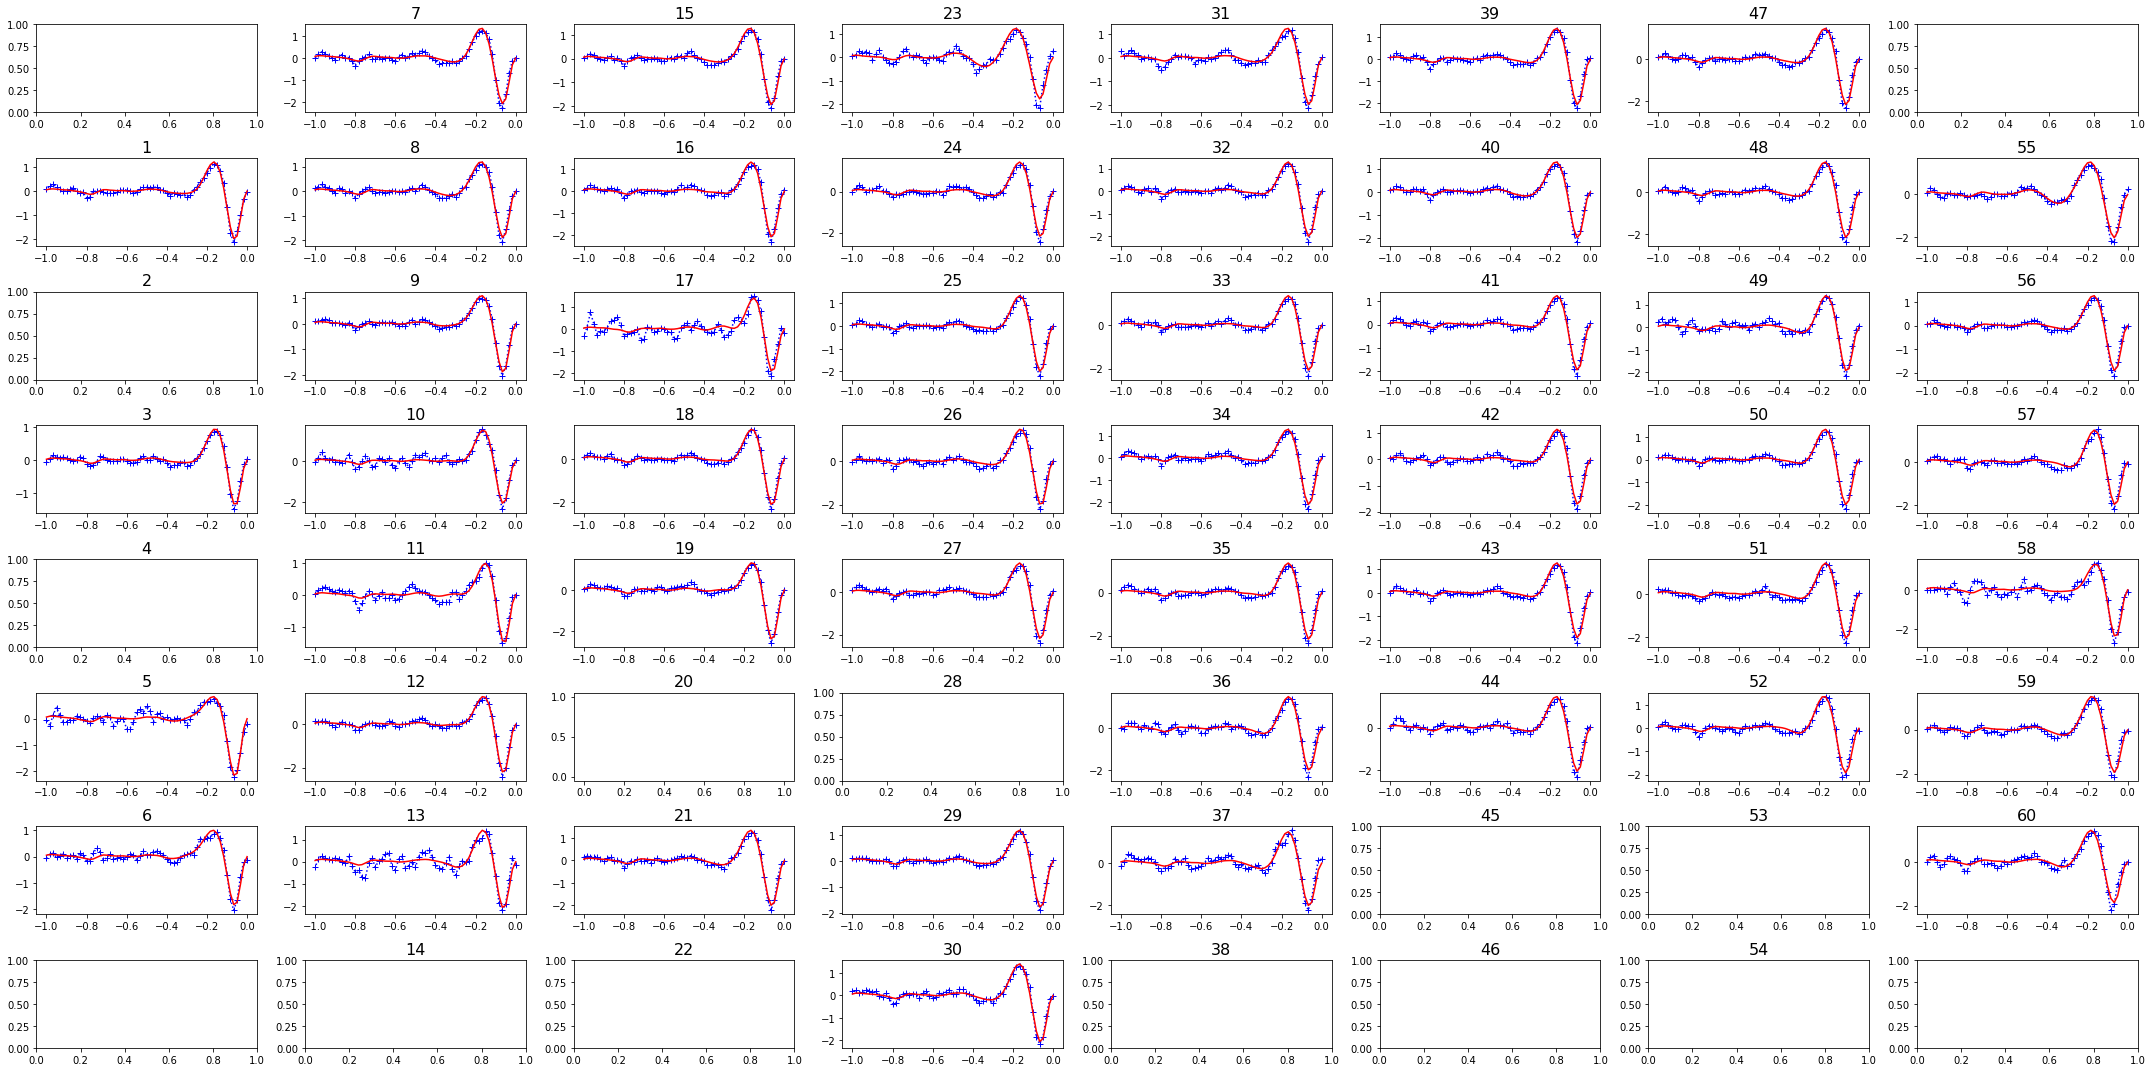

In [7]:
for cn in range(60):
    ax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 16)
fig.set_size_inches(30, 15)
fig.tight_layout()
fig

# examine date


## exclude on cell

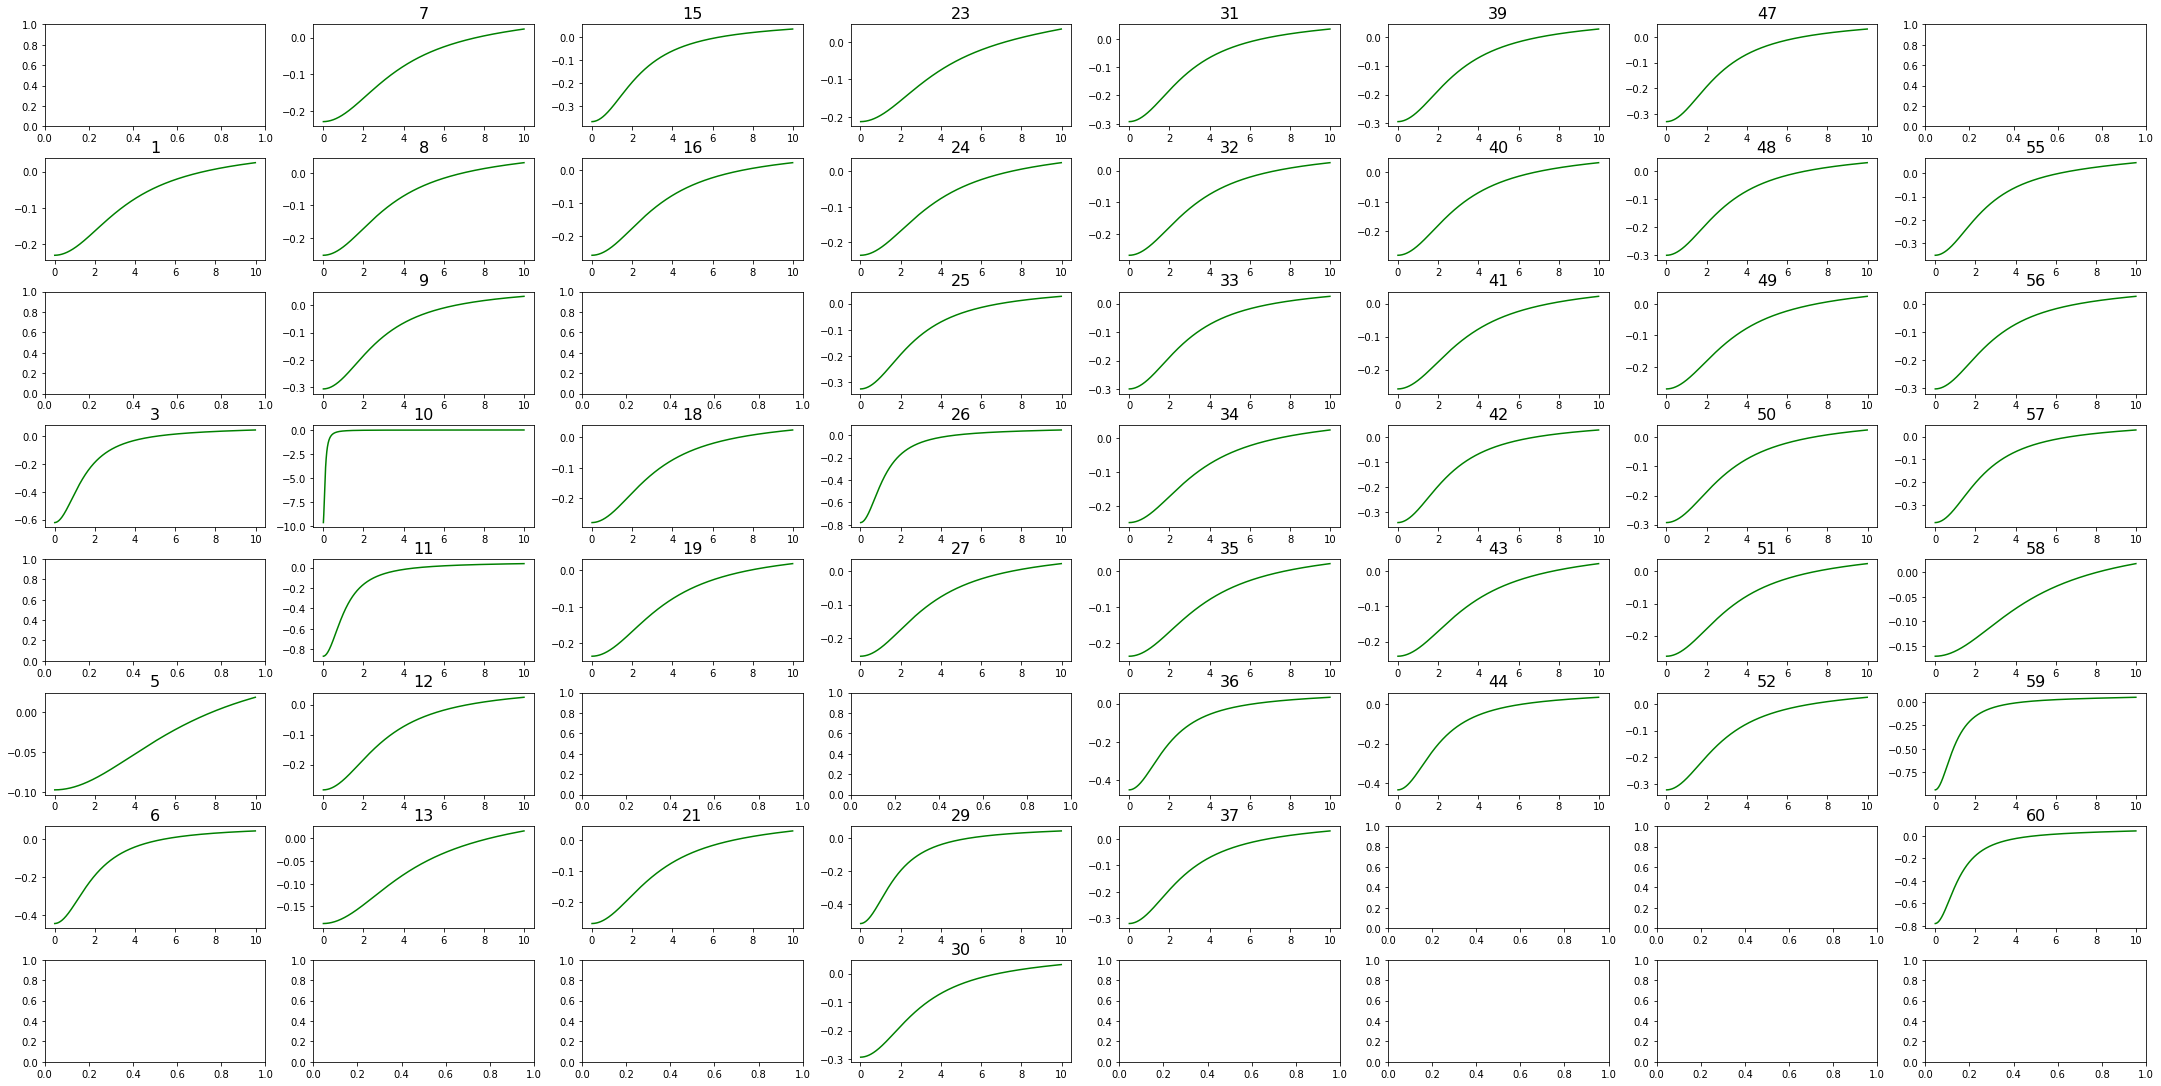

In [9]:
Dfig, Dax = plt.subplots(nrows=8, ncols=8)
Dfig.set_size_inches(30, 15)
Dfig.tight_layout()
pcn = []
ncn = []
for cn in dcn:
    #constrani 1
    if len(annots['reconstruct_spikes'][cn])/180 < 0.3: continue
    alpha = para_dict['alpha'][cn]
    beta = para_dict['beta'][cn]
    kg = para_dict['Kg'][cn]
    dOmega = 0.01
    omega = np.arange(dOmega,10,dOmega)
    H = 1/(omega*1j+alpha+(kg/(omega*1j+beta)))#/(omega*1j)
    G = np.abs(H)
    Phi = np.angle(H)
    delta = -np.append(np.diff(Phi),0)/dOmega
    Dax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 16)
        
    #constrani 2
    if delta[0] < 0: 
        pcn.append(cn)
        Dax[np.where(figmap == cn+1)][0].plot(omega[:-1], delta[:-1], 'g')
    else: 
        ncn.append(cn)
        Dax[np.where(figmap == cn+1)][0].plot(omega[:-1], delta[:-1], 'm')

In [10]:
# Dfig.set_size_inches(50, 25)
# Dfig.tight_layout()
# Dfig.savefig('D:\\GoogleDrive\\retina\\Chou\'s data\\20210331\\FIG\\GroupDely.tiff', bbox_inches = 'tight',pad_inches = 0.3)

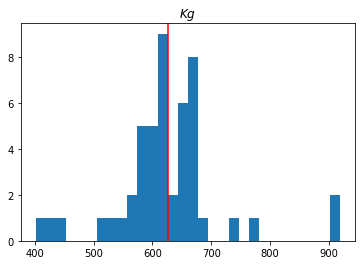

In [23]:
data = para_dict['Kg']
plt.title(r'$Kg$')
plt.hist(data[pcn],30)
plt.axvline(np.mean(data[pcn]), color = 'r')

In [12]:
I1 = np.where((para_dict['beta']>10) & (para_dict['beta']<40) )[0]
I2 = np.where((para_dict['beta']<=10) & (para_dict['beta']>0))[0]

Text(0, 0.5, '$\\beta$')

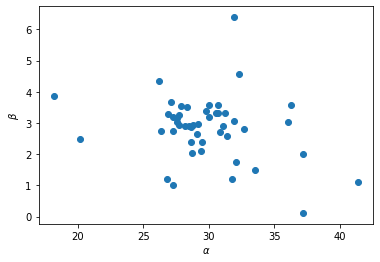

In [13]:
plt.scatter(para_dict['alpha'][pcn], para_dict['beta'][pcn])
# plt.scatter(para_dict['alpha'][I1], para_dict['beta'][I1], c='r')
# plt.scatter(para_dict['alpha'][I2], para_dict['beta'][I2], c='b')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

Text(0, 0.5, '$Kg$')

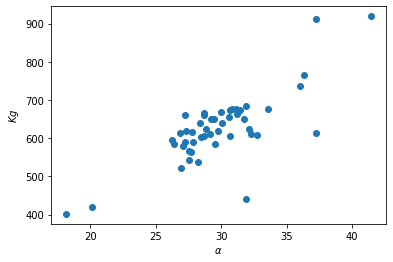

In [14]:
plt.scatter(para_dict['alpha'][pcn], para_dict['Kg'][pcn])
# plt.scatter(1/para_dict['alpha'][I1], para_dict['Kg'][I1], c='r')
# plt.scatter(1/para_dict['alpha'][I2], para_dict['Kg'][I2], c='b')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Kg$')

Text(0, 0.5, '$Kg$')

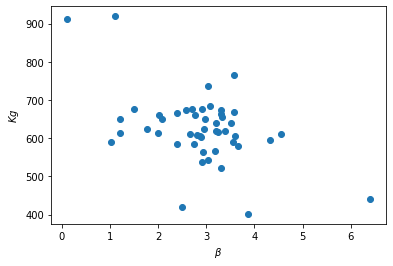

In [15]:
plt.scatter(para_dict['beta'][pcn], para_dict['Kg'][pcn])
# plt.scatter(1/para_dict['beta'][I1], para_dict['Kg'][I1], c='r')
# plt.scatter(1/para_dict['beta'][I2], para_dict['Kg'][I2], c='b')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$Kg$')

Text(0, 0.5, '$\\tau_y$')

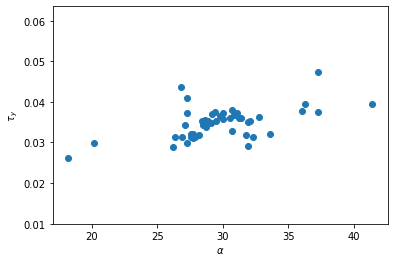

In [16]:
plt.scatter(para_dict['alpha'][pcn], para_dict['tau_y'][pcn])
# plt.scatter(para_dict['alpha'][I1], para_dict['tau_y'][I1], c='r')
# plt.scatter(para_dict['alpha'][I2], para_dict['tau_y'][I2], c='b')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\tau_y$')

Text(0, 0.5, '$\\tau_y$')

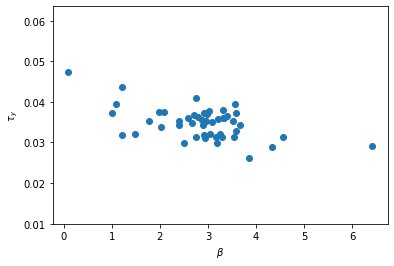

In [24]:
plt.scatter(para_dict['beta'][pcn], para_dict['tau_y'][pcn])
# plt.scatter(para_dict['alpha'][I1], para_dict['tau_y'][I1], c='r')
# plt.scatter(para_dict['alpha'][I2], para_dict['tau_y'][I2], c='b')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\tau_y$')

# view parameters

In [17]:
import pandas as pd
data_df = pd.DataFrame(para_dict, index = np.arange(60)+1)
data_df

,alpha,beta,Kg,tau_y,Amp,error
1,30.684535,3.590643,605.815291,0.032818,1.218471,0.599664
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,33.565440,1.494960,676.378599,0.032051,0.869138,0.351849
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,31.894537,6.405507,441.081007,0.029167,1.231821,1.794155
6,37.228975,1.993690,614.358955,0.037498,1.108765,1.048978
7,27.085477,3.661829,580.385482,0.034357,1.307135,1.034718
8,26.916613,3.299894,520.874225,0.031410,1.189416,0.759933
9,32.726344,2.798764,607.639189,0.036382,1.157100,0.399134
10,37.235877,0.100746,910.882617,0.047315,1.342929,1.888653
